In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'yatishchutani'
os.environ['KAGGLE_KEY'] = 'afd6b49cc0422703891eb002820d9690'
!rm -r /content/sample_data
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip
!rm -r /content/animals10.zip
!rm -r /content/translate.py

rm: cannot remove '/content/sample_data': No such file or directory
 99%|███████████████████████████████████████▌| 580M/586M [00:06<00:00, 99.4MB/s]
100%|████████████████████████████████████████| 586M/586M [00:06<00:00, 89.4MB/s]
Archive:  animals10.zip
  inflating: raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg  
  inflating: raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg  
  inflating: raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg  
  inflating: raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg  
  inflating: raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg  
  inflating: raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg  
  inflating: raw-img/cane/OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg  
  inflating: raw-img/cane/OIP--0CZnfLuBERVtzRm2QbB3gHaK4.jpeg  
  inflating: raw-img/cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4.jpeg  
  inflating: raw-img/cane/OIP--2uTtzjaszBfEMCROuLN3wHaLH.jpeg  
  inflating: raw-img/cane/OIP--2z_zAuTMzgYM_KynUl9CQHaE7.jpeg  
  inflating: raw-img/cane/OIP--565fkAJy3DoFs81

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import StepLR
import time
import torch.nn as nn
from datetime import datetime

2024-04-19 22:20:29.820486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 22:20:29.820614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 22:20:29.952024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter()
])

full_dataset = datasets.ImageFolder('/kaggle/working/raw-img', transform=transform)
class_counts = {class_name: 0 for class_name in full_dataset.classes}
for _, index in full_dataset.samples:
    class_name = full_dataset.classes[index]
    class_counts[class_name] += 1
print("Total number of classes:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)
print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f" - {class_name}: {count}")

Total number of classes: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Number of images per class:
 - cane: 4863
 - cavallo: 2623
 - elefante: 1446
 - farfalla: 2112
 - gallina: 3098
 - gatto: 1668
 - mucca: 1866
 - pecora: 1820
 - ragno: 4821
 - scoiattolo: 1862


In [5]:
train_size = int(0.8 * len(full_dataset))
test_validation_size = len(full_dataset) - train_size
validation_size = test_validation_size // 2
test_size = test_validation_size - validation_size

train_dataset, test_validation_dataset = random_split(full_dataset, [train_size, test_validation_size])
validation_dataset, test_dataset = random_split(test_validation_dataset, [validation_size, test_size])

print("Size of the entire Dataset: ", len(full_dataset))
print("Size of the training Dataset: ", len(train_dataset))
print("Size of the validation Dataset: ", len(validation_dataset))
print("Size of the test Dataset: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Size of the entire Dataset:  26179
Size of the training Dataset:  20943
Size of the validation Dataset:  2618
Size of the test Dataset:  2618


In [6]:
vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(
    vgg16.classifier[6].in_features, 10
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
simple_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
writer = SummaryWriter(f'runs/{simple_name}')
model_save_path = 'vgg16_best_model.pth'

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
patience = 5
best_val_loss = np.inf
patience_counter = 0
epochs = 25
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    vgg16.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total_train
    writer.add_scalar('Loss/Train', train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    vgg16.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / total_val
    writer.add_scalar('Loss/Validation', val_loss / len(validation_loader), epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    if val_loss / len(validation_loader) < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss / len(validation_loader):.6f}). Saving model ...")
        best_val_loss = val_loss / len(validation_loader)
        torch.save(vgg16.state_dict(), model_save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, "
      f"Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss / len(validation_loader):.4f}, "
      f"Val Accuracy: {val_accuracy:.2f}%")
writer.close()

Validation loss decreased (inf --> 1.814195). Saving model ...
Epoch 1: Train Loss: 2.0661, Train Accuracy: 26.77%, Val Loss: 1.8142, Val Accuracy: 38.54%
Validation loss decreased (1.814195 --> 1.594320). Saving model ...
Epoch 2: Train Loss: 1.7061, Train Accuracy: 41.44%, Val Loss: 1.5943, Val Accuracy: 45.45%
Validation loss decreased (1.594320 --> 1.461033). Saving model ...
Epoch 3: Train Loss: 1.5086, Train Accuracy: 48.63%, Val Loss: 1.4610, Val Accuracy: 51.30%
Validation loss decreased (1.461033 --> 1.380083). Saving model ...
Epoch 4: Train Loss: 1.3723, Train Accuracy: 53.18%, Val Loss: 1.3801, Val Accuracy: 52.56%
Validation loss decreased (1.380083 --> 1.281414). Saving model ...
Epoch 5: Train Loss: 1.2389, Train Accuracy: 57.62%, Val Loss: 1.2814, Val Accuracy: 57.94%
Validation loss decreased (1.281414 --> 1.139354). Saving model ...
Epoch 6: Train Loss: 1.1168, Train Accuracy: 61.85%, Val Loss: 1.1394, Val Accuracy: 61.65%
Validation loss decreased (1.139354 --> 0.995

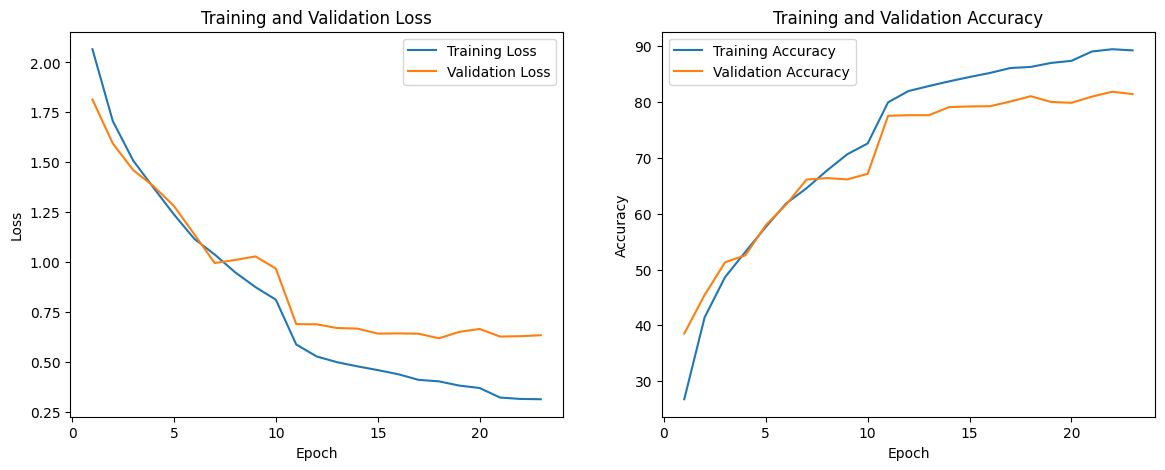

In [8]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = '/kaggle/working/runs/2024-04-19_22-21-23'
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

def extract_scalar(event_acc, tag):
    if tag in event_acc.Tags()['scalars']:
        return [scalar.value for scalar in event_acc.Scalars(tag)]
    else:
        return []

train_losses = extract_scalar(event_acc, 'Loss/Train')
train_accuracies = extract_scalar(event_acc, 'Accuracy/Train')
val_losses = extract_scalar(event_acc, 'Loss/Validation')
val_accuracies = extract_scalar(event_acc, 'Accuracy/Validation')
test_losses = extract_scalar(event_acc, 'Loss/Test')
test_accuracies = extract_scalar(event_acc, 'Accuracy/Test')
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
if test_losses:
    plt.axhline(y=test_losses[0], color='r', linestyle='-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
if test_accuracies:
    plt.axhline(y=test_accuracies[0], color='r', linestyle='-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2618 samples in 0.023s...
[t-SNE] Computed neighbors for 2618 samples in 4.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2618
[t-SNE] Computed conditional probabilities for sample 2000 / 2618
[t-SNE] Computed conditional probabilities for sample 2618 / 2618
[t-SNE] Mean sigma: 8.663762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.224960
[t-SNE] KL divergence after 300 iterations: 3.119416


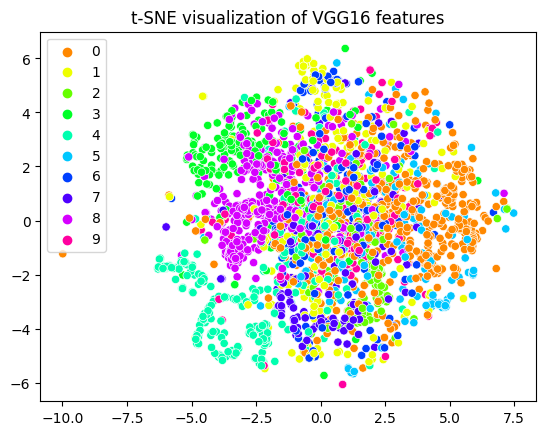

In [14]:
from sklearn.manifold import TSNE
class VGG16Features(nn.Module):
    def __init__(self, original_model):
        super(VGG16Features, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children()))
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

vgg16_features = VGG16Features(vgg16).to(device)

def extract_features(data_loader, model):
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().detach().numpy())
            labels.extend(label.numpy())

    return np.array(features), np.array(labels)

features, labels = extract_features(validation_loader, vgg16_features)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, legend='full', palette=sns.color_palette("hsv", 10))
plt.title('t-SNE visualization of VGG16 features')
plt.show()

Test Accuracy: 83.27%


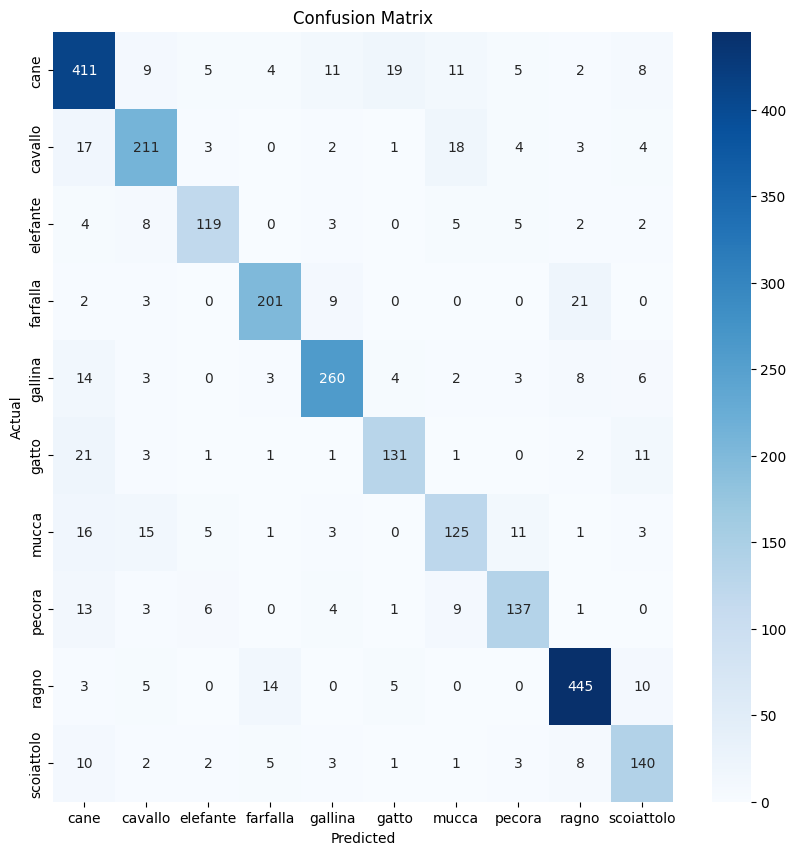

In [15]:
from sklearn.metrics import accuracy_score
vgg16.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\033[1mTest Accuracy: {accuracy * 100:.2f}%\033[0m")
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=full_dataset.classes, output_dict=True)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(true_labels, predicted_labels, target_names=full_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

        cane       0.80      0.85      0.83       485
     cavallo       0.81      0.80      0.80       263
    elefante       0.84      0.80      0.82       148
    farfalla       0.88      0.85      0.86       236
     gallina       0.88      0.86      0.87       303
       gatto       0.81      0.76      0.78       172
       mucca       0.73      0.69      0.71       180
      pecora       0.82      0.79      0.80       174
       ragno       0.90      0.92      0.91       482
  scoiattolo       0.76      0.80      0.78       175

    accuracy                           0.83      2618
   macro avg       0.82      0.81      0.82      2618
weighted avg       0.83      0.83      0.83      2618



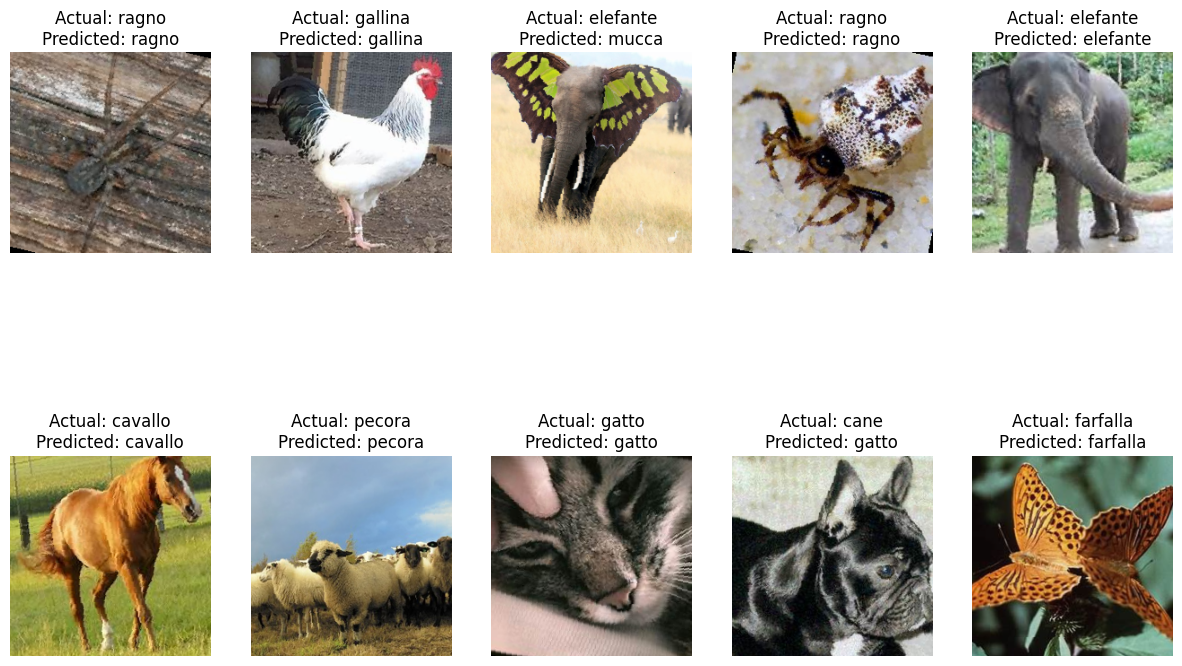

In [18]:
def imshow_with_labels(images, labels, predicted_labels):
    """Display images with labels."""
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1)
    axs = axs.flatten()
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Actual: {full_dataset.classes[labels[i]]}\nPredicted: {predicted_labels[i]}')
        axs[i].axis('off')
    plt.show()
images, labels = next(iter(test_loader))
num_images = 10
images_to_show = images[:num_images]
labels_to_show = labels[:num_images]
images_to_show = images_to_show.to(device)
outputs = vgg16(images_to_show)
_, preds = torch.max(outputs, 1)
predicted_labels = [full_dataset.classes[pred] for pred in preds]
imshow_with_labels(images_to_show, labels_to_show, predicted_labels)